<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовим-выборки" data-toc-modified-id="Подготовим-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовим выборки</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#RidgeClassifier" data-toc-modified-id="RidgeClassifier-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>RidgeClassifier</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тест" data-toc-modified-id="Тест-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тест</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Итоговая-таблица" data-toc-modified-id="Итоговая-таблица-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Итоговая таблица</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import tqdm
import re
import nltk
import time

from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

rnd_st = 12345

In [2]:
try:
    data = pd.read_csv("/datasets/toxic_comments.csv")
except:
    data = pd.read_csv("datasets/toxic_comments.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<AxesSubplot:>

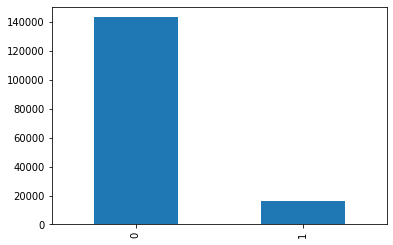

In [6]:
data['toxic'].value_counts().plot(kind='bar')

Всего 16тыс. строк из 159571 тыс. являются токсичными. 

Наблюдается дисбаланс классов.

In [7]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [8]:
data.duplicated().sum()

0

Пропусков и дубликатов не обнаружено

In [9]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Стоп-слова загружены

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.tokenize import sent_tokenize
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
def clear_text(text):
    text = text.lower()
    a = re.sub(r'[^a-zA-Z]'," ",text)
    a_1 = a.split()
    return " ".join(a_1)

In [12]:
#data["clear_text"] = data["text"].apply(clear_text)

In [13]:
#data.head()

In [12]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])

In [16]:
"""
%%time
data["lemm_text"] = data["clear_text"].apply(lemmatize_text)
"""

'\n%%time\ndata["lemm_text"] = data["clear_text"].apply(lemmatize_text)\n'

In [17]:
"""
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

data['lemm_text'] = data['text'].apply(lemmatize_text)
"""

'\n%%time\n\nm = Mystem()\n\ndef lemmatize_text(text):\n    text = text.lower()\n    lemm_text = "".join(m.lemmatize(text))\n    cleared_text = re.sub(r\'[^a-zA-Z]\', \' \', lemm_text) \n    return " ".join(cleared_text.split())\n\ndata[\'lemm_text\'] = data[\'text\'].apply(lemmatize_text)\n'

In [38]:
# КОД РЕВЬЮЕРА

lemmatize_text(clear_text('Aleksandr wants to be approved (1@*23&^#%@&* He goes 123 to lessons every day !"@!121")'))

'aleksandr want to be approve he go to lesson every day'

In [29]:
import string
punctuation = string.punctuation
wordnet_lemmatizer = WordNetLemmatizer()

In [37]:
def tokenizer(text):
    #Определение слова токенов
    tokens = [ word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    tokens = list(filter(lambda t: t not in punctuation, tokens)) # Уборка знаков припенания внутри слов
    tokens = list(filter(lambda t: t.lower() not in stopwords, tokens)) #Уборка стоп-слов
    filtered_tokens = []
    for token in tokens: # Регулярные выражений
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_tokens = list(
        map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens)) #Лемматизаци токенов
    filtered_tokens = list(filter(lambda t: t not in punctuation, filtered_tokens)) # Фильтр пл знаков припенания
    return ' '.join(filtered_tokens)

In [36]:
# КОД РЕВЬЮЕРА

tokenizer('Aleksandr wants to be approved (1@*23&^#%@&* He goes 123 to lessons every day !"@!121")')

'aleksandr want approved go lesson every day'

In [39]:
data['lemm_text'] = data['text'].map(tokenizer)

In [40]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour 'm seemingly stu...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man 'm really trying edit war 's guy const...
3,"""\nMore\nI can't make any real suggestions on ...",0,ca n't make real suggestion improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page 's


Текст лемматизирован

In [41]:
toxic_comments = data.drop(['text'], axis=1)

In [42]:
toxic_comments.head(15)

,toxic,lemm_text
0,0,explanation edits made username hardcore metal...
1,0,d'aww match background colour 'm seemingly stu...
2,0,hey man 'm really trying edit war 's guy const...
3,0,ca n't make real suggestion improvement wonder...
4,0,sir hero chance remember page 's
5,0,congratulation well use tool well talk
6,1,cocksucker piss around work
7,0,vandalism matt shirvington article reverted pl...
8,0,sorry word 'nonsense offensive anyway 'm inten...
9,0,alignment subject contrary dulithgow


Разделим датасет на обущающую, валидационную и тестовую выборку

In [43]:
train, valid = train_test_split(toxic_comments,
                               test_size=0.3,
                               random_state = rnd_st)

valid, test = train_test_split(valid,
                               test_size=0.5,
                               random_state = rnd_st)

In [44]:
print(f"Размер обущающей выборки: {train.shape}", f"Размер валидационной выборки: {valid.shape}", f"Размер тестовой выборки: {test.shape}", sep = "\n")

Размер обущающей выборки: (111699, 2)
Размер валидационной выборки: (23936, 2)
Размер тестовой выборки: (23936, 2)


### Вывод:

* Данные загружены
* Пропусков и дубликатов не обнаружено
* Текст был очистен и лемматизирован
* Наблюдается дисбаланс классов, токсичных комментариев примерно 10% от всех
* Исходный датасет был разбит на: обущающую, валидационную и тестовую выборку

В качестве баланса класса, в дальнейшем буду использовать `Class weight` в моделях

## Обучение

### Подготовим выборки

Подготовим тестовую выборку

In [45]:
target_train = train['toxic']

In [46]:
train_corpus = train['lemm_text']

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tfidf_train = count_tf_idf.fit_transform(train_corpus)

Подготовим валидационную выборку

In [47]:
valid_target = valid['toxic']

valid_corpus = valid['lemm_text']

tfidf_valid = count_tf_idf.transform(valid_corpus)

### Логистическая регрессия

In [48]:
%%time

LR = LogisticRegression(class_weight='balanced', random_state = rnd_st)

LR.fit(tfidf_train, target_train)

lr_predicted = LR.predict(tfidf_valid)

f1_lr = f1_score(valid_target, lr_predicted)
accurace_lr = accuracy_score(valid_target, lr_predicted)

print(f"F1 модели равен: {f1_lr}", f"Точность модели равна: {accurace_lr}", sep ="\n")

F1 модели равен: 0.7470313062252608
Точность модели равна: 0.9412600267379679
CPU times: user 18.8 s, sys: 21 s, total: 39.8 s
Wall time: 40 s


### DecisionTreeClassifier

In [30]:
"""
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(1,51)],
                'random_state':[12345],
                'class_weight':["balanced"]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=5)
clf.fit(tfidf_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
"""

'\nclassificator = DecisionTreeClassifier()\nhyperparams = [{\'max_depth\':[x for x in range(1,51)],\n                \'random_state\':[12345],\n                \'class_weight\':["balanced"]}]\n\n\nprint(\'# Tuning hyper-parameters for f1_score\')\nprint()\nclf = GridSearchCV(classificator, hyperparams, scoring=\'f1\',cv=5)\nclf.fit(tfidf_train, target_train)\nprint("Best parameters set found on development set:")\nprint()\nDTC_best_params = clf.best_params_\nprint(DTC_best_params)\nprint()\n'

In [49]:
%%time

DTC = DecisionTreeClassifier(class_weight='balanced', random_state = rnd_st, max_depth = 32)

DTC.fit(tfidf_train, target_train)

dtc_predicted = DTC.predict(tfidf_valid)

f1_dtc = f1_score(valid_target, dtc_predicted)
accurace_dtc = accuracy_score(valid_target, dtc_predicted)

print(f"F1 модели равен: {f1_dtc}", f"Точность модели равна: {accurace_dtc}", sep ="\n")

F1 модели равен: 0.6246354049809288
Точность модели равна: 0.930105280748663
CPU times: user 24.1 s, sys: 25.8 ms, total: 24.1 s
Wall time: 24.1 s


### CatBoostClassifier

In [32]:
"""
%%time

classificator = CatBoostClassifier(iterations=100, class_weights='balanced',random_state = rnd_st)

classificator.fit(tfidf_train, target_train)

target_predict = classificator.predict(tfidf_valid)

f1_cbc = f1_score(valid_target, target_predict)
accurace_cbc = accuracy_score(valid_target, target_predict)

print(f"F1 модели равен: {f1_cbc}", f"Точность модели равна: {accurace_cbc}", sep ="\n")
"""

'\n%%time\n\nclassificator = CatBoostClassifier(iterations=100, class_weights=\'balanced\',random_state = rnd_st)\n\nclassificator.fit(tfidf_train, target_train)\n\ntarget_predict = classificator.predict(tfidf_valid)\n\nf1_cbc = f1_score(valid_target, target_predict)\naccurace_cbc = accuracy_score(valid_target, target_predict)\n\nprint(f"F1 модели равен: {f1_cbc}", f"Точность модели равна: {accurace_cbc}", sep ="\n")\n'

CatBoost убивает ядро. Не понимаю из-за чего

### RidgeClassifier

In [50]:
%%time

model_clf = RidgeClassifier(class_weight = "balanced",random_state = rnd_st)

model_clf.fit(tfidf_train, target_train)

predicted_clf = model_clf.predict(tfidf_valid)

f1_clf = f1_score(valid_target, predicted_clf)
accurace_clf = accuracy_score(valid_target, predicted_clf)
print(f"F1 модели равен: {f1_clf}", f"Точность модели равна: {accurace_clf}", sep ="\n")

F1 модели равен: 0.2700093653195014
Точность модели равна: 0.5766627673796791
CPU times: user 10 s, sys: 14.2 s, total: 24.3 s
Wall time: 24.3 s


### LinearSVC

In [51]:
%%time

model_svc = LinearSVC(random_state = rnd_st, C = 2.5, max_iter = 5, class_weight = "balanced")

model_svc.fit(tfidf_train, target_train)

predicted_svc = model_svc.predict(tfidf_valid)

f1_svc = f1_score(valid_target, predicted_svc)
accurace_svc = accuracy_score(valid_target, predicted_clf)

print(f"F1 модели равен: {f1_svc}", f"Точность модели равна: {accurace_svc}", sep ="\n")

F1 модели равен: 0.7805985552115584
Точность модели равна: 0.5766627673796791
CPU times: user 314 ms, sys: 23.8 ms, total: 338 ms
Wall time: 344 ms


### Вывод:

* Были протестированы разные моедли
* Значение F1 по условию преодалели только 2 модели: LinearSVC и LogisticRegression.
* Наилучшее значение получилось у LinearSVC: F1 = 0.7902374670184698

## Тест

### Проверка модели на тестовой выборке 

In [52]:
target_test = test['toxic']

In [53]:
test_corpus = test['lemm_text']

In [54]:
tfidf_test = count_tf_idf.transform(test_corpus)

In [55]:
predicted_svc_test = model_svc.predict(tfidf_test)

f1_svc_test = f1_score(target_test, predicted_svc_test)
accurace_svc_test = accuracy_score(target_test, predicted_svc_test)

print(f"F1 модели равен: {f1_svc_test}", f"Точность модели равна: {accurace_svc_test}", sep ="\n")

F1 модели равен: 0.7739165985282093
Точность модели равна: 0.9537934491978609


На тесте значение F1 получилось выше 0.75, что соответствует условию задания

### Итоговая таблица

In [39]:
data_itog = pd.DataFrame({"Model":["LogisticRegression",
                                   "DecisionTreeClassifier",
                                  "RidgeClassifier",
                                  "LinearSVC",
                                  "LinearSVC_test"],
                          "F1":[f1_lr,f1_dtc,f1_clf,f1_svc,f1_svc_test],
                          "Accurace":[accurace_lr,accurace_dtc,accurace_clf,accurace_svc,accurace_svc_test]
                         })

In [40]:
data_itog.sort_values(by = "F1",ascending = False)

,Model,F1,Accurace
3,LinearSVC,0.780599,0.576663
4,LinearSVC_test,0.773917,0.953793
0,LogisticRegression,0.747031,0.941260
1,DecisionTreeClassifier,0.624635,0.930105
2,RidgeClassifier,0.270009,0.576663


## Выводы

* Были загружены данные и проанализированы. В итоге найден дисбаланс классов: токсичных комментариев составляет примерно 10% от всех комментариев. Пропусков и дубликатов не обнаружено;
* Текст был очистен и лемматизирован;
* Исходный датасет был разбит на: обущающую, валидационную и тестовую выборку;
* Протестированы различные модели. Наилучший результат показала LinearSVC. F1 составил 0.790237;
* На тесте данная модель показала значение F1 = 0.780296, что соответствует условию задания.